In [1]:
# reload external functions
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
import math
import os

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import voyageai
from dotenv import load_dotenv
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from data_cleaning import clean_url

# Load the .env file with the voyage api key
load_dotenv()

# Retrieve voyageAI API key (this is a free embeddings model, you just have to sign in)
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")
vo = voyageai.Client(api_key=VOYAGE_API_KEY)

pd.set_option("display.max_colwidth", 50)



/Users/eimearnolan/anaconda3/envs/moz_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read in jsonline file and port inot dataframe for analysis
FILE_PATH = 'data/AssignmentData.jsonl'

# create dataframe to store results
serp_list = []

# Open and try read the file
try:
    with jsonlines.open(FILE_PATH) as reader:
            
        for obj in reader:
            # flattening list of lists of search terms if they exist
            # or else just leave the empty list
            if len(obj['related_searches'])>0:
                obj['related_searches'] = obj.get('related_searches')[0]
            serp_list.append(obj)
        
except FileNotFoundError:
    print('File not found')
except Exception as e:
    print(f"Encountered exception {e}")        
        

serp_df = pd.DataFrame(serp_list)
print(f'Number of SERPs: {len(serp_df)} \n')
serp_df.head()



Number of SERPs: 150 



,related_searches,search_results
0,"[border design, border css, border patrol numb...","[{'url': 'https://www.cbp.gov/', 'title': 'U.S..."
1,"[Counseling near me, counselling or counseling...",[{'url': 'https://www.counseling.org/aca-commu...
2,"[field meaning in hindi, field meaning in urdu...",[{'url': 'https://www.merriam-webster.com/dict...
3,"[kick meaning, what is kick online, kick movie...",[{'url': 'https://www.merriam-webster.com/dict...
4,"[seasons name, seasons of the year, seasons & ...",[{'url': 'https://www.nationalgeographic.org/e...


## Basic Data Analysis

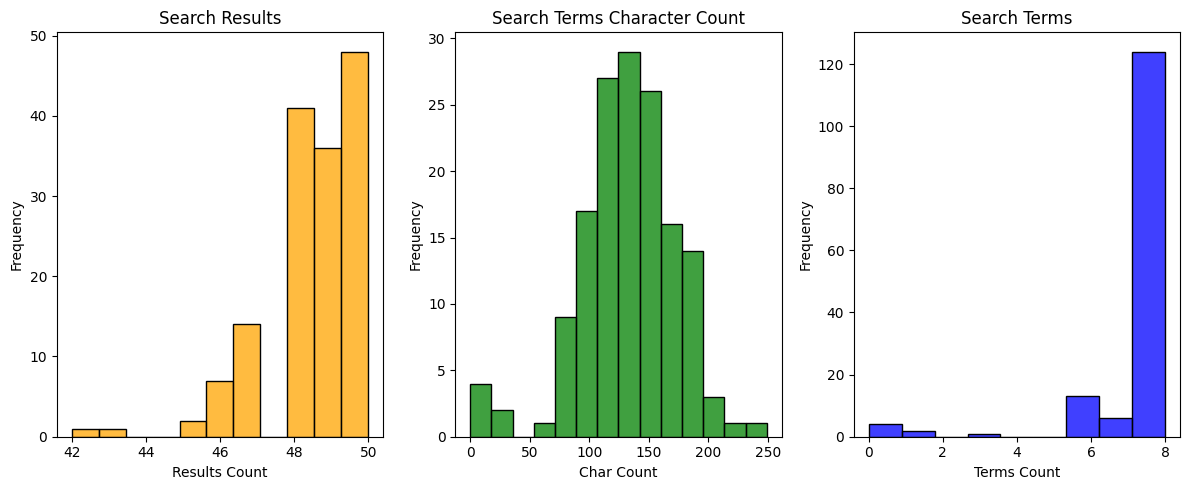

In [4]:
# How many searches terms, how many results, what empty fields are there?

serp_df['term_count'] = serp_df['related_searches'].apply(lambda x: len(x))
serp_df['term_chars_count'] = serp_df['related_searches'].apply(lambda x: len(' '.join(x))) # useful for knowing when embeddings come in later on
serp_df['results_count'] = serp_df['search_results'].apply(lambda x: len(x))

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Histogram of results_count
sns.histplot(serp_df['results_count'], kde=False, color='orange', ax=axes[0])
axes[0].set_title('Search Results')
axes[0].set_xlabel('Results Count')
axes[0].set_ylabel('Frequency')

# Histogram of term_chars_count
sns.histplot(serp_df['term_chars_count'], kde=False, color='green', ax=axes[1])
axes[1].set_title('Search Terms Character Count')
axes[1].set_xlabel('Char Count')
axes[1].set_ylabel('Frequency')

# Histogram of term_count
sns.histplot(serp_df['term_count'], kde=False, color='blue', ax=axes[2])
axes[2].set_title('Search Terms')
axes[2].set_xlabel('Terms Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [5]:
# histogram shows records with zero search terms, remove them from clustering 

serp_df_zero_terms = serp_df[serp_df['term_count']==0]
serp_df = serp_df[serp_df['term_count']>0].reset_index(drop = True)

print(f"Number of records after removing records with zero search terms: {len(serp_df)} \n")
print(f"Verify removed records have no search terms : \n {serp_df_zero_terms}")

Number of records after removing records with zero search terms: 146 

Verify removed records have no search terms : 
     related_searches                                     search_results  \
46                []  [{'url': 'https://www.merriam-webster.com/dict...   
90                []  [{'url': 'https://www.tropicalsmoothiecafe.com...   
116               []  [{'url': 'https://www.merriam-webster.com/dict...   
126               []  [{'url': 'https://eab.com/products/navigate/',...   

     term_count  term_chars_count  results_count  
46            0                 0             49  
90            0                 0             42  
116           0                 0             48  
126           0                 0             49  


In [6]:

# Any dulplicte rows of related search terms?
print(f'Number of SERP before deduping: {len(serp_df)} \n')
serp_df = serp_df.drop_duplicates(subset=['related_searches']).reset_index(drop = True)
print(f'Number of SERP after deduping: {len(serp_df)} \n')


Number of SERP before deduping: 146 

Number of SERP after deduping: 146 



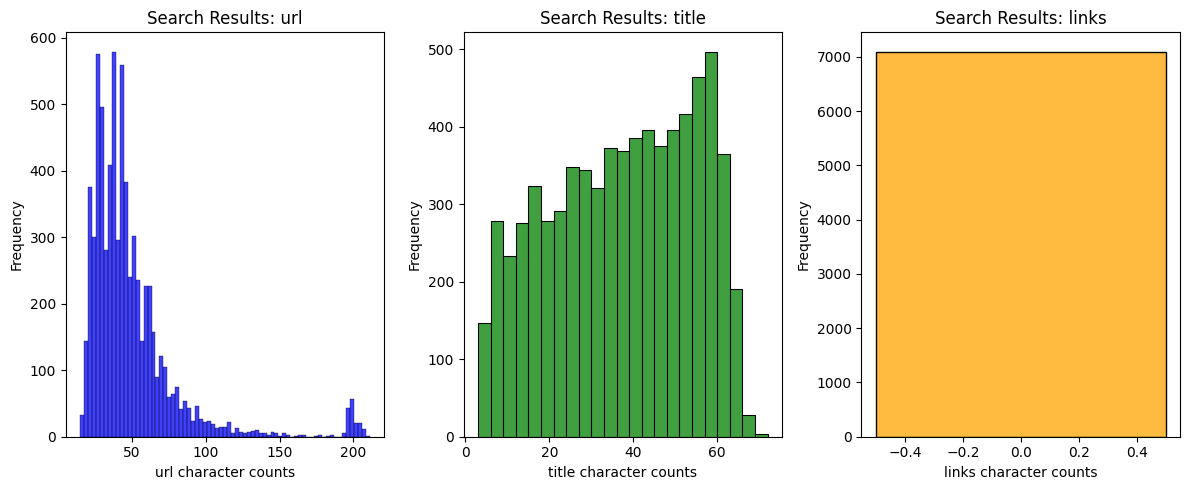

In [7]:
# stack search results and examine basic counts of characters

# before exploding I'm going to add an id so I can aggregate it back up afterwards
serp_df['id'] = serp_df.index
unnested_df = serp_df.explode('search_results')

# Convert the dictionaries in search_results to separate columns
search_results_df = unnested_df['search_results'].apply(pd.Series)
search_results_df['id'] = unnested_df['id'].values

search_results_df['url_count'] = search_results_df['url'].apply(lambda x: len(x))
search_results_df['title_count'] = search_results_df['title'].apply(lambda x: len(x))
search_results_df['link_count'] = search_results_df['links'].apply(lambda x: len(x))

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Histogram of url chars
sns.histplot(search_results_df['url_count'], kde=False, color='blue', ax=axes[0])
axes[0].set_title('Search Results: url')
axes[0].set_xlabel('url character counts')
axes[0].set_ylabel('Frequency')

# Histogram of title chars
sns.histplot(search_results_df['title_count'], kde=False, color='green', ax=axes[1])
axes[1].set_title('Search Results: title')
axes[1].set_xlabel('title character counts')
axes[1].set_ylabel('Frequency')

# Histogram of title chars
sns.histplot(search_results_df['link_count'], kde=False, color='orange', ax=axes[2])
axes[2].set_title('Search Results: links')
axes[2].set_xlabel('links character counts')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
# links are not useful and some very short titles
# may need to remove tracking params from some urls from that character spike around the 200 mark

# only set here to view urls
pd.set_option('display.max_colwidth', None)

short_titles_df = search_results_df[search_results_df['title_count']<5]
print(f"Example of short titles: \n {short_titles_df['title'][0:5]} \n")

long_urls_df = search_results_df[search_results_df['url_count']>150]
print(f"Number of long urls:\n {len(long_urls_df)} \n")
print(f"Example of long urls:\n {long_urls_df['url'][:5]} \n")


Example of short titles: 
 6     swim
6     Swim
11    Play
11    play
16     Map
Name: title, dtype: object 

Number of long urls:
 179 

Example of long urls:
 0    https://books.google.com/books?id=-MdFAQAAMAAJ&pg=PA77&lpg=PA77&dq=border&source=bl&ots=b76r3BWrOW&sig=ACfU3U2EOQAabp_Fi9oeGlfvv-TUjee0fg&hl=en&sa=X&ved=2ahUKEwjCm8za2fCDAxWttokEHRxXCf0Q6AF6BQi7ARAD
0      https://books.google.com/books?id=s4-kJi7TIgwC&pg=PA4&lpg=PA4&dq=border&source=bl&ots=WaLStk3Aaz&sig=ACfU3U3HmgAtaFv4BfaorHMrZyNaUfpRbA&hl=en&sa=X&ved=2ahUKEwjCm8za2fCDAxWttokEHRxXCf0Q6AF6BQi5ARAD
0      https://books.google.com/books?id=yu4kFC_vNokC&pg=PP1&lpg=PP1&dq=border&source=bl&ots=tAL4JNOr99&sig=ACfU3U10jo4KB0m_g5swB9r5gX20rdwdbw&hl=en&sa=X&ved=2ahUKEwjCm8za2fCDAxWttokEHRxXCf0Q6AF6BQi2ARAD
0    https://books.google.com/books?id=rV1JAAAAMAAJ&pg=PA84&lpg=PA84&dq=border&source=bl&ots=-2NdIeG79I&sig=ACfU3U3xs_OQbSg9jBbfQJMjh9Jphg2EJg&hl=en&sa=X&ved=2ahUKEwjCm8za2fCDAxWttokEHRxXCf0Q6AF6BQi8ARAD
1                     

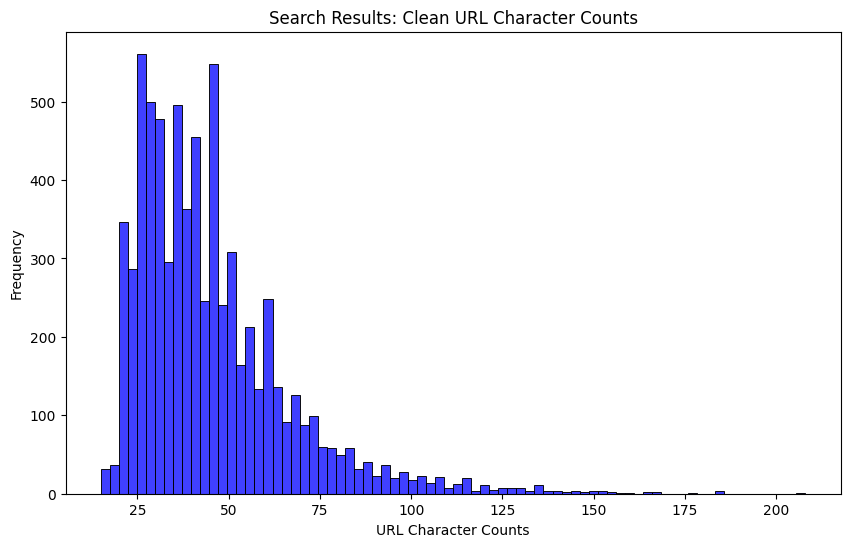

Number of long urls:
 16 

Example of long urls:
                                                                                                     url  \
18  https://www.lindenwood.edu/academics/support-resources/student-academic-and-support-services/aca...   
24  https://www.fda.gov/medical-devices/personal-protective-equipment-infection-control/n95-respirat...   
35  https://www.gov.uk/government/publications/health-protection-in-schools-and-other-childcare-faci...   
49  https://www.denvergov.org/Government/Agencies-Departments-Offices/Agencies-Departments-Offices-D...   
65  https://doh.wa.gov/data-and-statistical-reports/diseases-and-chronic-conditions/communicable-dis...   

                                                                                              clean_url  
18  https://www.lindenwood.edu/academics/support-resources/student-academic-and-support-services/aca...  
24  https://www.fda.gov/medical-devices/personal-protective-equipment-infection-control/n95-res

In [9]:
# clean urls and remove links and aggregate dataframe back together 

pd.set_option('display.max_colwidth', 100)

search_results_df['clean_url'] = search_results_df['url'].apply(lambda x: clean_url(x, hostname_only = False))
search_results_df['url_hostname'] = search_results_df['url'].apply(lambda x: clean_url(x, hostname_only = True))
search_results_df['clean_url_count'] = search_results_df['clean_url'].apply(lambda x: len(x))

# Plot the histogram
plt.figure(figsize=(10, 6))  # Adjust the size as needed
sns.histplot(search_results_df['clean_url_count'], kde=False, color='blue')
plt.title('Search Results: Clean URL Character Counts')
plt.xlabel('URL Character Counts')
plt.ylabel('Frequency')
plt.show()


long_urls_df = search_results_df[search_results_df['clean_url_count']>150]
print(f"Number of long urls:\n {len(long_urls_df)} \n")
print(f"Example of long urls:\n {long_urls_df[['url', 'clean_url']][:5]} \n")


In [38]:
# aggregate exploded dataframe back together 

# instead of dicts, use a flat list of strings for each of the search results
aggregated_df = search_results_df.groupby('id').agg({'url': list, 'clean_url': list, 'url_hostname': list, 'title': list, 'rank': list})

# merge back to get related_search terms
serp_result_cleaned_df = pd.merge(serp_df, aggregated_df, left_on=serp_df.id, right_on='id', how='left')
serp_result_cleaned_df.to_csv('data/serp_cleaned_df.csv', index=False)



## Semantic clustering

Clustering on Search Engine Results Pages (SERPs) data using k-means clustering applied to transformer embeddings. Visualized using t-SNE.
More details found in the find_cluster_id function docstring. This is done on different inputs form the cleaned SERP dataframe namely:

 1. exploded serp df and used individual related search terms (then can get the overall cluster_id through majority voting)
 2. exploded serp df and used individual titles (then can get the overall cluster_id through majority voting)
 3. related search terms concatenated together
 4. concatenated related search terms with titles from the first 10 search results


In [49]:
def find_cluster_ids(serps:pd.DataFrame, embed_list: list, cluster_breakdown: bool = False, perplexity: int = 10, learning_rate = 4000)->pd.DataFrame:

    """Clustering on Search Engine Results Pages (SERPs) data using k-means clustering applied to transformer embeddings.
    This function takes a DataFrame containing SERPs data and a list of strings (extracted from the SERPs) as inputs.
    It processes these strings through the "voyage-lite-02-instruct" embedding model to convert them into a high-dimensional vector space,
    facilitating the clustering of similar SERPs based on their content's semantic similarity.
    
    The high-dimensional embedding space is reduced to two dimensions using t-SNE (t-Distributed Stochastic Neighbor Embedding)
    for visualization purposes.

    Returns:
        dataframe: original dataframe with cluster_id column
    """
    
    #  Embeds a list of strings to a dimension of 1024 using vogage embeddings model
    # choosing model based off of embeddings clustering rank table: https://huggingface.co/blog/mteb
    batch_size = 128 # this is the max it can embed at one time
    embeddings = []

    for i in range(0, len(embed_list), batch_size):
        embeddings[i:i + batch_size] = vo.embed(
            embed_list[i:i + batch_size], model="voyage-lite-02-instruct"
        ).embeddings
        
    
    # run k means
    # matrix 146 x 1024 (serp number x embeddings size)
    #from sklearn.metrics.pairwise import cosine_similarity
    #embeddings=pd.DataFrame(cosine_similarity(embeddings,dense_output=True))
    
    matrix = np.array(embeddings)
    matrix = np.vstack(matrix)
    n_clusters = 3

    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
    kmeans.fit(matrix)
    serps['cluster_id'] = kmeans.labels_
    
    # visualize using t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="random", learning_rate=learning_rate)
    vis_dims2 = tsne.fit_transform(matrix)
    print(f'KL divergence: {tsne.kl_divergence_}')
    
    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    for category, color in enumerate(["purple", "green", "red"]):
        xs = np.array(x)[serps['cluster_id'] == category]
        ys = np.array(y)[serps['cluster_id'] == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        # plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
    plt.title("SERP Clusters visualized in 2d using t-SNE")
    

    # sample from clusters and observe themes
    sample_per_cluster = 5

    for i in range(n_clusters):
        print(f"Cluster {i}: \n", end=" ")

        sample_cluster_rows = serps[serps['cluster_id'] == i].sample(sample_per_cluster, random_state=42)
        print(pd.Series(sample_cluster_rows['related_searches']))

        print("-" * 100)
        
    if cluster_breakdown:
        # see breakdown of clusters
        plt.figure(figsize=(10, 6))  # Adjust the size as needed
        sns.histplot(serps['cluster_id'], bins=n_clusters, kde=False, color='blue')
        plt.title('Cluster Breakdowns')
        plt.xlabel('cluster ID')
        plt.ylabel('SERP Count')
        plt.xticks(range(int(serps['cluster_id'].min()), 
                        int(serps['cluster_id'].max()) + 1))

        plt.show()
    
    return serps
        

### 1. Exploded serp df and use individual related search terms 

(then can get the overall cluster_id through majority voting)


KL divergence: 1.1033533811569214
Cluster 0: 
 132               Referee meaning
4         how to pronounce season
30     skills: definition example
33      schedule meaning in hindi
8       itinerary meaning in urdu
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 1: 
 17               well ap
1        Free counseling
65      illness examples
74    treatment in hindi
66     mental health pdf
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 2: 
 52        repair apple
16     google map live
22       roadtrip band
50          Cheer team
140          racing fc
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------


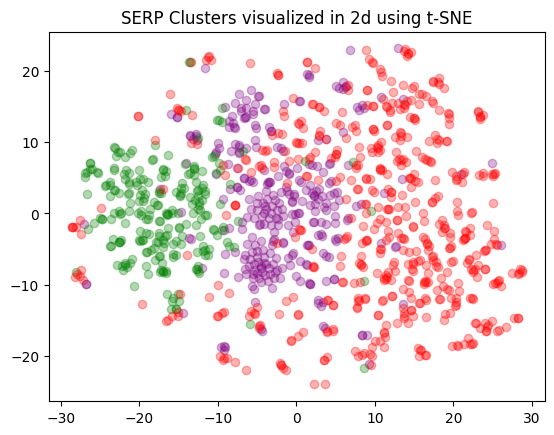

In [48]:
# embed, cluster and visualize all the individual related search terms
column = 'related_searches'

unnested_serp_search_terms_df = serp_result_cleaned_df.explode(column)
embed_list = unnested_serp_search_terms_df[column].tolist()

serps_w_cluster_search_terms = find_cluster_ids(unnested_serp_search_terms_df, embed_list, perplexity = 100)



### 2. Exploded serp df and use individual titles 

(then can get the overall cluster_id through majority voting)

KL divergence: 1.5580321550369263
Cluster 0: 
 2     [field meaning in hindi, field meaning in urdu, how to pronounce field, what is fields in comput...
31    [backpack travel, backpack for school, backpack amazon, backpack nike, backpack for men, girls b...
42    [international example, international synonym, international school, international news, interna...
53    [program in computer, program meaning in english, program in hindi, program spelling, example of...
6     [swim movie, swim acronym, swim wheres981, swim verb, how to pronounce swim, swim in spanish, sw...
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 1: 
 36    [disability nj, disability definition, what conditions qualify for disability?, disability calcu...
77    [hobby ideas, my hobby, hobby synonym, hobby or hobbie, hobby lobby, hobby meaning in hindi, wha...
53    [program in computer, program meaning in english, pro

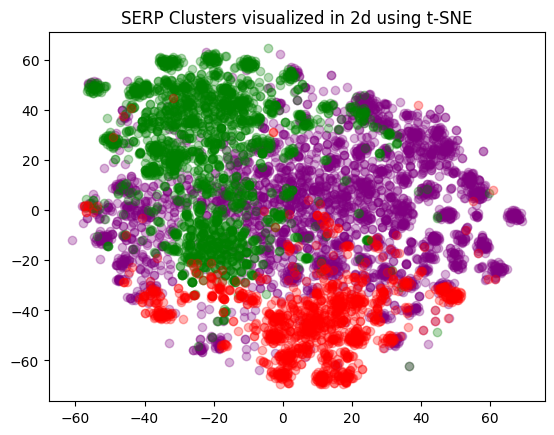

In [50]:
# embed, cluster and visualize all the titles individual

column = 'title'

unnested_serp_search_terms_df = serp_result_cleaned_df.explode(column)
embed_list = unnested_serp_search_terms_df[column].tolist()

serps_w_cluster_titles = find_cluster_ids(unnested_serp_search_terms_df, embed_list,  perplexity = 100)

### 3. related search terms concatenated together


KL divergence: 2.8667378425598145
Cluster 0: 
 121    [traveler or traveller, travelers insurance, t...
54     [Bus schedule, flixbus, Bus tickets, school bu...
113    [taxi near me, taxi film, taxi service, taxi i...
109    [luggage sets, luggage nearby, luggage bag, lu...
62     [women's dsw shoes, shoe carnival, shoe carniv...
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 1: 
 144    [health app, health card, health id, health in...
47     [doctor near me, doctor wikipedia, doctor in h...
95     [therapy near me, mental health therapy, psych...
106    [healthcare or health care, healthcare marketp...
65     [illness meaning in hindi, illness examples, h...
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 2: 
 6      [swim movie, swim acronym, swim wheres981, swi...
123    [remedy meaning

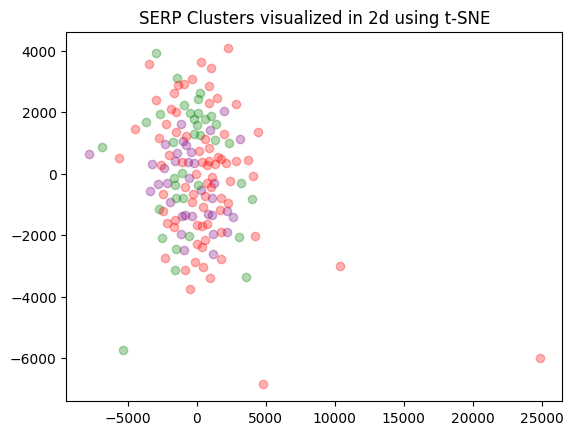

In [52]:
# embed, cluster and visualize all the related search terms together i.e. a list of search terms concatentated as a string

serp_df_embed = serp_result_cleaned_df.copy()
serp_df_embed["concat_search_terms"] = serp_df_embed['related_searches'].apply(lambda x: ", ".join(x))
search_embed_list = serp_df_embed["concat_search_terms"].to_list()

serps_w_cluster_concat_search_terms = find_cluster_ids(serp_df_embed, search_embed_list, learning_rate = 2000)

    

### 4. concatenated related search terms with titles from the first 10 search results


KL divergence: 2.6839189529418945
Cluster 0: 
 143    [train band, train tickets, train verb, train ...
64     [jersey shirt, jersey ropa, jersey football, i...
127    [booking hotel, booking.com login, booking ext...
83     [cruise meaning, cruise car, cruise ship, crui...
25     [airplane movie, airplane ticket, airplane dra...
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 1: 
 138    [physician vs doctor, physician salary, physic...
74     [Treatment synonym, Treatment definition, trea...
97     [medicines names, medicine online, medicine jo...
81     [nurse salary, types of nurse, registered nurs...
36     [disability nj, disability definition, what co...
Name: related_searches, dtype: object
----------------------------------------------------------------------------------------------------
Cluster 2: 
 55    [how to pronounce tour, tour meaning in hindi,...
2     [field meaning in

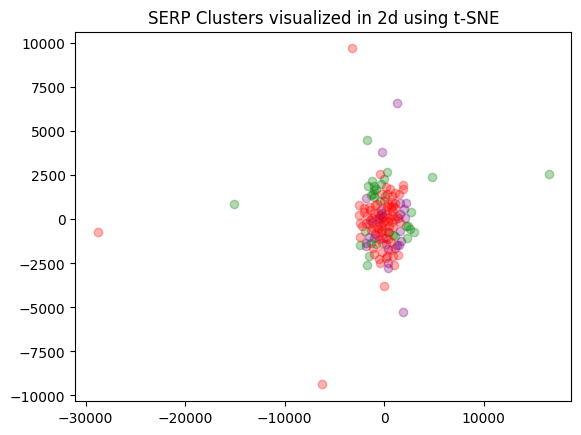

In [53]:
# embed, cluster and visualize all the related search terms together with the first ten titles i.e. a list of search terms and titles concatentated as a string

def concat_top_list(list_titles: list, n = 5)-> str:
    """takes the first ten search results and concats the titles
    truncted as the embeddings models will max out """
    list_string = ''
    for res in list_titles[:n]:
         list_string = list_string + ' ' + res
         
    return list_string

serp_df_embed["concat_titles_terms"] = serp_df_embed['related_searches'].apply(lambda x: ", ".join(x)) + ' ' +serp_df_embed['clean_url'].apply(lambda x: concat_top_list(x))
search_embed_list = serp_df_embed["concat_titles_terms"].to_list()

serps_w_cluster_concat_search_terms_titles = find_cluster_ids(serp_df_embed, search_embed_list, learning_rate = 2000)


### Observations

- unsupervised clustering when concatenating fields doesn't give good class seperation, the embedding doesn't seem capable of reflecting the mulitple entities in the string
- best results when clustering on singular fields e.g. search term or titles. I'll then using majority voting on the results to get the overall cluster id


In [45]:
# majority voting using individual search terms to reach final cluster ID

# Find most common cluster_id from the search terms individual cluster id
def most_common(x):
    return mode(x)[0]

# Aggregate back to df where all related seach terms are together
aggregated_df = serps_w_cluster_search_terms.groupby('id').agg({
    'related_searches': list,  # Aggregating related_searches into a list
    'cluster_id': most_common  # Taking the most common cluster_id
})

# merge back with original cleaned serp df
serps_w_cluster_search_terms_maj_vote = pd.merge(serp_result_cleaned_df, aggregated_df, on=['id'], how='left')
serps_w_cluster_search_terms_maj_vote.to_csv('data/serp_cluster_results.csv', index=False)



### Basic SERP analysis

How many base urls appear across different related search term lists?

In [75]:
# get overlap of urls found by different lists of search terms

url_fragment = 'clean_url' # 'url_hostname'
url_to_search_terms = {}

for search_terms, urls, id in zip(serp_result_cleaned_df['related_searches'], serp_result_cleaned_df[url_fragment], serp_result_cleaned_df['id']):
    for url in urls:
        if url in url_to_search_terms:
            url_to_search_terms[url]['related_searches'].update(search_terms)
            url_to_search_terms[url]['ids'].add(str(id))
        else:
            url_to_search_terms[url] = {'related_searches': set(search_terms), 'ids' : set(str(id)) }

# only kepp instances when the urls has appeared from more than one list of search terms
overlapping_urls = {url: info for url, info in url_to_search_terms.items() if len(info['ids']) > 1}

for url, info in overlapping_urls.items():
    info['related_searches'] = list(info['related_searches'])
    info['ids'] = list(info['ids'])

# How many url results come from different related earch terms?
print(f'Overlapping URL instances: {len(overlapping_urls)}\n')

for url, info in list(overlapping_urls.items())[:20]:
    print(f"URL: {url}  with Serp IDs: {info['ids']} overlaps with search terms: {info['related_searches']}")
    

Overlapping URL instances: 5893

URL: https://www.cbp.gov/  with Serp IDs: ['32', '0'] overlaps with search terms: ['border mexico', 'border design', 'border css', 'customs and border protection officer', 'customs duty', 'u.s. customs questions and answers', 'u.s. customs and border protection phone number', 'u.s. border crossing', 'u.s. customs and border protection form', 'border movie', 'what are customs in culture', 'customs office', 'border patrol number', 'us customs and border protection', 'u.s. border']
URL: https://i94.cbp.dhs.gov/  with Serp IDs: ['32', '0'] overlaps with search terms: ['border mexico', 'border design', 'border css', 'customs and border protection officer', 'customs duty', 'u.s. customs questions and answers', 'u.s. customs and border protection phone number', 'u.s. border crossing', 'u.s. customs and border protection form', 'border movie', 'what are customs in culture', 'customs office', 'border patrol number', 'us customs and border protection', 'u.s. bord

## Conclusion

### Semantic clustering:

- the three clusters seem to break down predominantly as follows:
    - travel/transport
    - healthcare
    - sports/recreation
- unsupervised clustering when concatenating fields doesn't give good class seperation, the embedding cdoesn't seem capable of reflecting the mulitple entities in the string
- best results when clustering on singular fields e.g. search term or title then using majority voting on the results to get the overall cluster id

#### Could try instead:
- using rank and identifying if any urls are shared across related search terms
- change kmeans to use cosine similarity as the distance metric, reduce dimensionality using UMAP before running clustering or try DBSCAN as a comparison
- optimize clustering and t-SNE hyperparameters like perplexity with bayesian search
- using traditional topic clustering like latent Dirichlet allocation to look at stemmed word counts
- use a model with a smaller embeddings size e.g. 512
- adding more info from urls e.g. fragments, paths
- using a sentence model like sbert for embedding the concatenated strings

### SERP clustering

had to cut off my time when I came to this but a few observations and potential directions:
- much more overlapping results than expected with the majority of urls found by multiple lists of search terms
- I'd look at how the search terms are related since they gave back the same url, are the overlaps coming from generic sites like youtube, wikipedia where the topics could be anything? 


